# GPM data combining and conversion

#### Combining the gpm highres nc4 datasets for each year and exporting to a singular classic netcdf dataset (individual for each year) to be used as input for nctoolkits cdo for regridding to lowres dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client, Variable
client = Client()
%matplotlib inline
%config IPCompleter.greedy = True

In [2]:
# from dask.diagnostics import ProgressBar

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='Blues')

In [26]:
ds1 = xr.open_dataset('./data/GPM_data/gpm_2005.nc')

In [6]:
ds1

<xarray.Dataset>
Dimensions:             (time: 17520, bnds: 2, lon: 401, lat: 401)
Coordinates:
  * time                (time) datetime64[ns] 2002-01-01 ... 2002-12-31T23:30:00
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    lon_bnds            (lon, bnds) float32 ...
    lat_bnds            (lat, bnds) float32 ...
    precipitationCal    (time, lon, lat) float32 ...
    precipitationUncal  (time, lon, lat) float32 ...
    IRprecipitation     (time, lon, lat) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Wed Oct 27 14:12:53 2021: cdo mergetime ...
    CDO:                             Climate Data Operators version 1.9.10 (h...

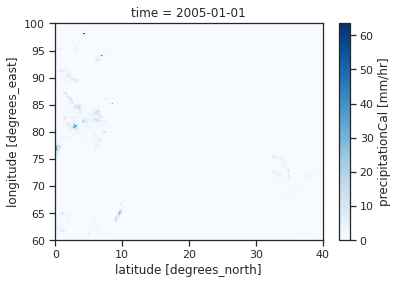

In [24]:
ds1.precipitationCal.isel(time = 0).plot()